In [45]:
using OnlineStats, AverageShiftedHistograms, Distributions

# OnlineStats.jl

- Josh Day, NC State Department of Statistics
- https://github.com/joshday/
- jtday2@ncsu.edu
- December 14, 2015

### Things to Note

- I am a statistician
- I am a Julia convert from R
- This talk will focus on OnlineStats, but I'll also be demonstrating a few things from Plots.jl (@tbreloff) and AverageShiftedHistograms.jl (@joshday)
- Some of the syntax I'm using is not yet available in OnlineStats

### Outline

- Introduction/Motivation
- Why Julia?
- What Can [OnlineStats.jl](https://github.com/joshday/OnlineStats.jl) do?
    - Weighting System
    - Trace Plots
    - Distribution Fitting
    - Density Estimation ([AverageShiftedHistograms.jl](https://github.com/joshday/AverageShiftedHistograms.jl))
    - Predictive Models with Regularization

### Introduction and Motivation

- OnlineStats.jl is the implementation of my research into online algorithms for statistics.
- Observations are processed one by one and all algorithms use O(1) memory.
- Why do we need online algorithms for statistics?

![](http://www.ibmbigdatahub.com/sites/default/files/infographic_file/4-Vs-of-big-data.jpg)

- Statistical methods in the realms of Volume and Velocity are very limited.  
- Adapting methods to these scenarios is nontrivial

# Why Julia? (vs. R + RCpp)

- Speed
- Types 
    - multiple dispatch and abstraction
- Developer tools
    - `@time`, the greatest thing
- Clarity
- The Future

# What Can OnlineStats.jl Do?

- http://joshday.github.io/OnlineStats.jl/#what-onlinestats-can-do
- OnlineStats aims to cover online algorithms for each major statistical method, from summary statistics to penalized regression.
- Some estimates cannot be exact, but many OnlineStats have analytical solutions
  - logistic regression (approximate)
  - linear regression (analytical)

In [46]:
using OnlineStats
y = randn(10_000_000);

In [57]:
o = Mean()
for yi in y
    fit!(o, yi)
end
# fit!(o, y, 5)

# Mean(y)

In [56]:
# Does it work?
mean(o) - mean(y)

4.412702842016003e-17

In [58]:
using Plots; gadfly()

o = Variance()

p = plot([0.], [0. 0.], lab = ["mean" "variance"])
anim = Animation()
for i in 1:100
    fit!(o, randn(10))
    push!(p, nobs(o), [mean(o), var(o)]) 
    frame(anim)
end

In [59]:
# Do mean and variance go to 0 and 1?
gif(anim, "TracePlot.gif")

INFO: Saved animation to /Users/joshday/github/TriangleJuliaUsers_OnlineStats/TracePlot.gif


Plots.AnimatedGif("/Users/joshday/github/TriangleJuliaUsers_OnlineStats/TracePlot.gif")

### Weight Types

OnlineStats has multiple weighting schemes built into the backend of every type.  This means new information can be weighted differently from past information.  Users can add their own types or use those built into OnlineStats:

- `EqualWeight`
- `ExponentialWeight`
- `LearningRate`

Updating a statistic often takes the form of a weighted average:

$\theta^{(t)} = (1 - \gamma_t)\theta^{(t-1)} + \gamma_t (\; newval \;), \quad 0 < \gamma_t \le 1$

If we are updating observations one-by-one:

- `EqualWeight` 
    - $\gamma_t = \frac{1}{t}$
- `ExponentialWeight(minstep)` 
    - uses `EqualWeight` until $\gamma_t \le minstep$, then stays constant at `minstep`
- `LearningRate(r)` 
    - $\gamma_t = \frac{1}{t^r}$

- `LearningRate` is mainly used for stochastic gradient descent (SGD) and its variants:

$$\theta^{(t)} = \theta^{(t-1)} - \gamma_t \; g_t$$

- SGD is a standard for creating online algorithms for statistical models. 

### `TracePlot`

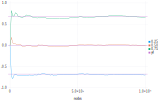

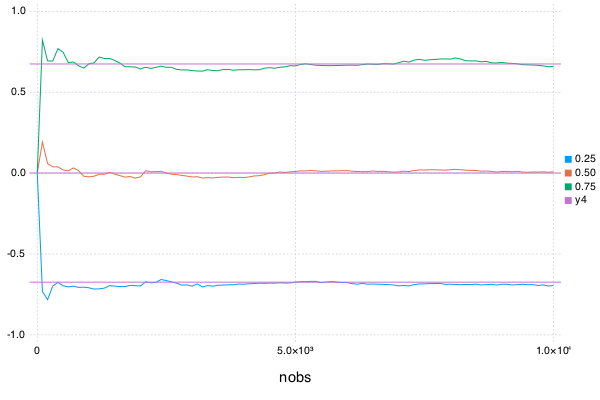

In [66]:
o = QuantileMM(LearningRate(.7))  # Online MM Algorithm for quantiles
tr = TracePlot(o, value, xlab = "nobs", lab = ["0.25" "0.50" "0.75"])
for i in 1:100 
    fit!(tr, randn(100)) 
end
plot(tr);  hline!(quantile(Normal(), [.25, .5, .75]))

### Distribution Fitting

Fitting specific distributions to data is available through the `FitDistribution` and `FitMvDistribution` types.  Most common types from the Distributions package are covered.

In [69]:
using Distributions
y2 = rand(Categorical([.25, .25, .25, .25]), 10_000_000)
@time FitDistribution(Categorical, y2)

▌ FitDistribution 
 •    value: Distributions.Categorical(K=4, p=[0.2501253,0.2499398,0.2499034,0.2500315])
 •     nobs: 10000000


0.086866 seconds (19 allocations: 1.203 KB)


In [70]:
y2 = rand(MvNormal(zeros(5), eye(5)), 100_000)'
@time FitMvDistribution(MvNormal, y2)

▌ FitMvDistribution 
 •    value: FullNormal(
dim: 5
μ: [0.0020810478626356087,-0.0026074631585960837,0.004216243721243169,0.0007313848349814912,-0.0001709372614677968]
Σ: 5x5 Array{Float64,2}:
  1.00169       0.00430865   0.000378094  -0.00381983   -0.00177773
  0.00430865    0.999192    -0.00198705   -0.00263692    0.00349144
  0.000378094  -0.00198705   0.995824      0.000428808   0.00506568
 -0.00381983   -0.00263692   0.000428808   1.00161      -0.00061303
 -0.00177773    0.00349144   0.00506568   -0.00061303    0.997444  
)

 •     nobs: 100000


0.009475 seconds (100.03 k allocations: 4.580 MB)


### Density Estimation with `AverageShiftedHistograms.jl`

- An Average Shifted Histogram is essentially a kernel density estimator using a fine-partition histogram instead of individual observations.  
- While you lose information by using ASH vs. KDE, complexity of the estimation doesn't grow with $n$.

In [43]:
using AverageShiftedHistograms
a = ash(y[1:10], -5:.1:5, m = 5)
p = plot(a.rng, a.y, ylims = (0, .5), xlab = "nobs: $(nobs(a))")
δ = a.rng.step / a.rng.divisor
plot!(a.rng, a.v / sum(δ * a.v), t = :step)
plot!(x -> pdf(Normal(), x), -4, 4)

rng = 11:20
anim = Animation()
frame(anim)
for i in 1:200
    fit!(a, y[rng], warnout = false)
    p2 = plot(a.rng, a.y, ylims = (0,.5), xlab = "nobs: $(nobs(a))")
    plot!(a.rng, a.v / sum(δ * a.v), t = :step)
    plot!(x -> pdf(Normal(), x), -4, 4)
    p.o = p2.o
    frame(anim)
    rng += 10
end

In [44]:
gif(anim, "ASH.gif")

INFO: Saved animation to /Users/joshday/github/TriangleJuliaUsers_OnlineStats/ASH.gif


Plots.AnimatedGif("/Users/joshday/github/TriangleJuliaUsers_OnlineStats/ASH.gif")

### Predictive Models with Regularization

Objective:  $$\text{minimize } L(\beta) = f(\beta) + \lambda g(\beta)$$


- Linear Regression: $f(\beta) = (y - x\beta)^T(y-x\beta)$
- Logistic Regression: $f(\beta) = -\sum\left[y_i x_i^T\beta - \ln(1 + e^{x_i^T\beta})\right]$


- Ridge Penalty: $g(\beta) = \sum \beta_i^2$
- LASSO Penalty: $g(\beta) = \sum |\beta_i|$

This framework is done through the `StatLearn` (statistical learning) type.

The building blocks of which are:

- `ModelDef`
    - Model definition, specifies link and loss functions
- `Penalty`
- `Algorithm` 

### `ModelDef`

- `L2Regression()`
- `L1Regression()`
- `LogisticRegression()`
- `PoissonRegression()`
- `QuantileRegression(tau)`
- `HuberRegression(delta)`
- `SVMLike()`

### Penalty

- `NoPenalty()`
- `L2Penalty()` (Ridge)
- `L1Penalty()` (LASSO)
- `ElasticNetPenalty(a)` (weighted avg. of ridge and LASSO)
- `SCADPenalty(a)` (smoothly clipped absolute deviation)

Penalties are currently handled by the prox operator:

$$\text{prox}_g(\theta) = \text{argmin}_u \left( g(u) + \frac{1}{2}\|u - \theta\|_2^2\right)$$

The intuition is a tradeoff between minimizing $g$ and remaining "close" to $\theta$.

### Algorithm

- `SGD()` (stochastic gradient descent)
- `AdaGrad()` (self-tuning weights, ignores `Weight`)
- `RDA()` (regularized dual averaging)
- `MMGrad()` (online MM Gradient)
- `AdaMMGrad()` (self-tuning weights, ignores `Weight`)

### Tangent about MM Algorithm

For a difficult-to-minimize objective, create a series of surrogate objectives that are easy to minimize.

![](mm_vis4.pdf)

In [71]:
# generate some data
n, p = 1_000, 10
x = randn(n, p)
β = collect(linspace(-1, 1, p))
y = x*β + randn(n);

# Compare models
o1 = StatLearn(p, model = L2Regression())
o2 = StatLearn(p, model = L1Regression())
o3 = StatLearn(p, model = HuberRegression(2.0))

tr = CompareTracePlot([o1, o2, o3], o -> mean(abs(y - predict(o,x))))
rng = 1:10

for i in 1:100
    yi = y[rng] 
    xi = x[rng, :]
    fit!(tr, xi, yi)
    rng += 10
end

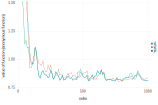

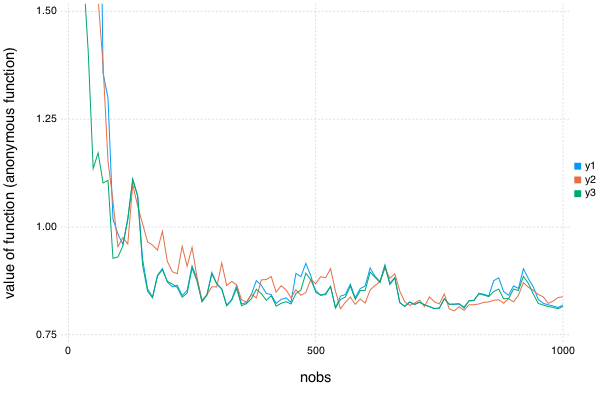

In [72]:
plot!(tr.p, ylims = (.75, 1.5))

### Cross Validation

Not yet included in the reorganization of OnlineStats.  For this type, the user provides a test data set.  With each update, several tuning parameters will be tried, and the winner is chosen by which minimizes error on the test set.

http://joshday.github.io/OnlineStats.jl/Models/StochasticModel/

### Advice for `StatLearn`

- Use when training time is the bottleneck
- Use traceplots of the loss on a test set
- If data is static, randomize the order of observations

### Thank You

- GitHub: @joshday
- Website: http://joshday.github.io
- Email: jtday2@ncsu.edu
